# Zenodo Journal Runner Detection - Exploratory Data Analysis

This notebook performs an explainable exploratory analysis of Zenodo records to identify users who appear to be running journals on the platform.

## Overview
- **Data Source**: 500,000+ JSON records from Zenodo (2025)
- **Goal**: Identify users with journal-running behavior patterns
- **Approach**: Feature engineering based on explainable heuristics


## 1. Configuration and Setup

In [91]:
# Configuration
import os
import json
import glob
from datetime import datetime
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Data processing
import pandas as pd
import numpy as np
from tqdm import tqdm
import pyarrow as pa
import pyarrow.parquet as pq

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Statistics
from scipy import stats

# Set up plotting style
plt.style.use('seaborn-v0_8')
rcParams['figure.figsize'] = (12, 8)
rcParams['font.size'] = 10

# Create output directories
os.makedirs('figures', exist_ok=True)
os.makedirs('data', exist_ok=True)

# Configuration parameters
CONFIG = {
    'json_dir': 'records-json-2025',
    'spam_file': 'records-deleted-2025.csv',
    'sample_size': None,  # Set to number for sampling, None for full dataset
    'chunk_size': 1000,   # Process files in chunks
    'min_records_threshold': 20,
    'external_doi_consistency_threshold': 0.7,  # 70% of external DOIs use same prefix
    'max_external_prefixes': 3,  # Max unique external DOI prefixes
    'min_upload_regularity': 0.1,  # Much more mild upload regularity threshold (was 0.3)
    'max_spam_ratio': 0.1,  # Max 10% spam records
    # Safe communities that indicate independent users (not journal runners)
    'safe_communities': ['eu', 'biosyslit'],  # EU Open Research Repository and Biodiversity Literature Repository
    'repetitive_author_threshold': 0.3,  # If 30% of entries have no author intersection, likely journal runner
    'min_author_intersection_ratio': 0.2  # Minimum ratio of entries that share at least one author
}

print(f"Configuration loaded. Processing directory: {CONFIG['json_dir']}")
print(f"Spam records file: {CONFIG['spam_file']}")

Configuration loaded. Processing directory: records-json-2025
Spam records file: records-deleted-2025.csv


## 2. Data Loading Functions

In [92]:
def load_spam_records(filepath):
    """Load spam records CSV file."""
    print(f"Loading spam records from {filepath}...")
    spam_df = pd.read_csv(filepath)
    print(f"Loaded {len(spam_df)} spam records")
    return spam_df

def extract_record_features(record):
    """Extract relevant features from a single JSON record."""
    try:
        # Basic record info
        record_id = record.get('id')
        created = record.get('created')
        
        # User info
        user_id = record.get('parent', {}).get('access', {}).get('owned_by', {}).get('user')
        
        # DOI info
        doi = record.get('pids', {}).get('doi', {}).get('identifier', '')
        is_zenodo_doi = doi.startswith('10.5281/zenodo.') if doi else False
        
        # External DOI prefix (for consistency analysis)
        external_doi_prefix = None
        if doi and not is_zenodo_doi and '/' in doi:
            external_doi_prefix = doi.split('/')[0]
        
        # Journal info
        journal_title = None
        if 'custom_fields' in record and \
           'journal:journal' in record['custom_fields']:
            journal_title = record['custom_fields']['journal:journal'].get('title')
        
        # Author analysis - extract all author names from the full author list
        creators = record.get('metadata', {}).get('creators', [])
        n_authors = len(creators) if creators else 0
        
        # Extract all author names for intersection analysis
        author_names = []
        if creators:
            for creator in creators:
                if 'person_or_org' in creator and 'name' in creator['person_or_org']:
                    author_names.append(creator['person_or_org']['name'])
        
        # Title analysis
        title = record.get('metadata', {}).get('title', '')
        
        # Community info - check both main record and parent, extract slug
        communities = []
        community_slugs = []
        if 'communities' in record and 'ids' in record['communities']:
            communities = record['communities']['ids']
        elif 'parent' in record and 'communities' in record['parent'] and 'ids' in record['parent']['communities']:
            communities = record['parent']['communities']['ids']
        
        # Extract community slugs
        if 'parent' in record and 'communities' in record['parent'] and 'entries' in record['parent']['communities']:
            for entry in record['parent']['communities']['entries']:
                if 'slug' in entry:
                    community_slugs.append(entry['slug'])
        
        # File info
        file_count = record.get('files', {}).get('count', 0)
        
        return {
            'record_id': record_id,
            'user_id': user_id,
            'created': created,
            'doi': doi,
            'is_zenodo_doi': is_zenodo_doi,
            'external_doi_prefix': external_doi_prefix,
            'journal_title': journal_title,
            'n_authors': n_authors,
            'author_names': author_names,
            'title': title,
            'communities': communities,
            'community_slugs': community_slugs,
            'file_count': file_count
        }
    except Exception as e:
        print(f"Error processing record {record.get('id', 'unknown')}: {e}")
        return None

def load_records_generator(json_dir, sample_size=None):
    """Generator function to load records in chunks for memory efficiency."""
    json_files = glob.glob(os.path.join(json_dir, '*.json'))
    
    if sample_size:
        json_files = json_files[:sample_size]
    
    print(f"Processing {len(json_files)} JSON files...")
    
    for filepath in tqdm(json_files, desc="Loading records"):
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                record = json.load(f)
                features = extract_record_features(record)
                if features:
                    yield features
        except Exception as e:
            print(f"Error reading {filepath}: {e}")
            continue

def load_records_to_dataframe(json_dir, sample_size=None):
    """Load all records into a pandas DataFrame."""
    records = list(load_records_generator(json_dir, sample_size))
    df = pd.DataFrame(records)
    
    # Convert created to datetime
    try:
        df['created'] = pd.to_datetime(df['created'], format='mixed', errors='coerce')
    except Exception as e:
        print(f"Warning: Some datetime parsing failed: {e}")
        # Fallback to more permissive parsing
        df['created'] = pd.to_datetime(df['created'], errors='coerce')
    
    # Remove rows where datetime parsing failed
    original_count = len(df)
    df = df.dropna(subset=['created'])
    if len(df) < original_count:
        print(f"Warning: Dropped {original_count - len(df)} records with invalid datetime")
    
    print(f"Loaded {len(df)} records from {df['user_id'].nunique()} unique users")
    return df

## 3. Load and Prepare Data

In [93]:
# Load spam records
spam_df = load_spam_records(CONFIG['spam_file'])
spam_record_ids = set(spam_df['record_id'].astype(str))

# Load main records
records_df = load_records_to_dataframe(CONFIG['json_dir'], CONFIG['sample_size'])

# Add spam flag
records_df['is_spam_record'] = records_df['record_id'].astype(str).isin(spam_record_ids)

print(f"\nData Summary:")
print(f"Total records: {len(records_df):,}")
print(f"Unique users: {records_df['user_id'].nunique():,}")
print(f"Spam records: {records_df['is_spam_record'].sum():,}")
print(f"Date range: {records_df['created'].min()} to {records_df['created'].max()}")

# Save records to parquet for future use
records_df.to_parquet('data/records.parquet', index=False)
print("\nRecords saved to data/records.parquet")

Loading spam records from records-deleted-2025.csv...
Loaded 72469 spam records
Processing 62356 JSON files...


Loading records: 100%|██████████| 62356/62356 [00:12<00:00, 5052.45it/s]


Loaded 62356 records from 6254 unique users

Data Summary:
Total records: 62,356
Unique users: 6,254
Spam records: 0
Date range: 2014-03-10 17:37:15+00:00 to 2025-06-26 09:26:24.715589+00:00

Records saved to data/records.parquet


## 4. Feature Engineering Functions

In [94]:
def calculate_burstiness(upload_times):
    """
    Calculate burstiness using coefficient of variation of inter-upload times.
    
    Burstiness measures how irregular or clustered the upload timing patterns are.
    A high burstiness value indicates uploads happen in concentrated bursts with 
    long gaps between them (typical of journal runners who upload many papers at once).
    A low burstiness value indicates regular, evenly-spaced uploads (typical of 
    normal academic users who upload papers as they complete them).
    
    The coefficient of variation (std/mean) of time intervals between uploads 
    captures this pattern - higher values mean more bursty behavior.
    """
    if len(upload_times) < 2:
        return 0.0
    
    # Sort times and calculate intervals
    sorted_times = sorted(upload_times)
    intervals = np.diff([t.timestamp() for t in sorted_times])
    
    if len(intervals) == 0 or np.std(intervals) == 0:
        return 0.0
    
    # Coefficient of variation
    cv = np.std(intervals) / np.mean(intervals)
    return cv

def extract_user_features(user_records):
    """Extract features for a single user from their records."""
    user_id = user_records['user_id'].iloc[0]
    
    # Basic counts
    n_records = len(user_records)
    
    # External DOI consistency (more important than Zenodo ratio)
    external_dois = user_records[~user_records['is_zenodo_doi']]['external_doi_prefix'].dropna()
    if len(external_dois) > 0:
        unique_prefixes = external_dois.nunique()
        most_common_prefix = external_dois.mode().iloc[0] if len(external_dois.mode()) > 0 else None
        external_doi_consistency = (external_dois == most_common_prefix).mean() if most_common_prefix else 0.0
    else:
        unique_prefixes = 0
        external_doi_consistency = 0.0
    
    # Author analysis - check for repetitive authors (this is the key feature for journal runners)
    all_author_lists = user_records['author_names'].dropna().tolist()
    no_repetitive_author_score = 0.0
    author_intersection_ratio = 0.0
    
    if len(all_author_lists) >= 2:
        # Calculate how many pairs of entries have no author intersection
        no_intersection_count = 0
        total_pairs = 0
        
        for i in range(len(all_author_lists)):
            for j in range(i+1, len(all_author_lists)):
                total_pairs += 1
                set1 = set(all_author_lists[i])
                set2 = set(all_author_lists[j])
                if len(set1.intersection(set2)) == 0:
                    no_intersection_count += 1
        
        if total_pairs > 0:
            no_repetitive_author_score = no_intersection_count / total_pairs
            author_intersection_ratio = 1.0 - no_repetitive_author_score
    
    # Journal title consistency
    journal_titles = user_records['journal_title'].dropna()
    distinct_journal_title_cnt = journal_titles.nunique()
    
    # Community analysis - check for safe communities
    all_community_slugs = []
    for community_slugs in user_records['community_slugs'].dropna():
        if isinstance(community_slugs, list):
            all_community_slugs.extend(community_slugs)
    
    # Check if user has any safe communities (indicates independent user)
    has_safe_community = any(slug in CONFIG['safe_communities'] for slug in all_community_slugs)
    
    # Community dedication ratio (kept as feature but no threshold)
    if all_community_slugs:
        community_counts = pd.Series(all_community_slugs).value_counts()
        most_common_community = community_counts.index[0]
        same_comm_ratio = community_counts.iloc[0] / len(all_community_slugs)
    else:
        same_comm_ratio = 0.0
    
    # Temporal analysis
    upload_times = user_records['created'].dropna()
    burstiness = calculate_burstiness(upload_times)
    
    # Upload regularity (how consistent are the intervals) - much more mild threshold
    upload_regularity = 0.0
    if len(upload_times) >= 3:
        sorted_times = sorted(upload_times)
        intervals = np.diff([t.timestamp() for t in sorted_times])
        # Lower coefficient of variation = more regular
        if np.mean(intervals) > 0:
            upload_regularity = 1.0 / (1.0 + np.std(intervals) / np.mean(intervals))
    
    # Spam association
    spam_record_cnt = user_records['is_spam_record'].sum()
    spam_record_ratio = spam_record_cnt / n_records if n_records > 0 else 0.0
    
    return {
        'user_id': user_id,
        'n_records': n_records,
        'external_doi_consistency': external_doi_consistency,
        'unique_external_prefixes': unique_prefixes,
        'no_repetitive_author_score': no_repetitive_author_score,
        'author_intersection_ratio': author_intersection_ratio,
        'distinct_journal_title_cnt': distinct_journal_title_cnt,
        'has_safe_community': has_safe_community,
        'same_comm_ratio': same_comm_ratio,
        'burstiness': burstiness,
        'upload_regularity': upload_regularity,
        'spam_record_cnt': spam_record_cnt,
        'spam_record_ratio': spam_record_ratio,
        'first_upload': upload_times.min() if len(upload_times) > 0 else None,
        'last_upload': upload_times.max() if len(upload_times) > 0 else None
    }

def create_user_features_df(records_df):
    """Create user-level features DataFrame."""
    print("Extracting user-level features...")
    
    user_features = []
    for user_id, user_records in tqdm(records_df.groupby('user_id'), desc="Processing users"):
        features = extract_user_features(user_records)
        user_features.append(features)
    
    users_df = pd.DataFrame(user_features)
    
    print(f"Created features for {len(users_df)} users")
    return users_df

## 5. Generate User Features

In [95]:
# Create user features
users_df = create_user_features_df(records_df)

# Display feature summary
print("\nUser Features Summary:")
print(users_df.describe())

# Save user features
users_df.to_parquet('data/users.parquet', index=False)
print("\nUser features saved to data/users.parquet")

# Show top users by record count
print("\nTop 10 users by record count:")
print(users_df.nlargest(10, 'n_records')[['user_id', 'n_records', 'external_doi_consistency', 'spam_record_cnt']])

Extracting user-level features...


Processing users: 100%|██████████| 6254/6254 [04:23<00:00, 23.74it/s]  

Created features for 6254 users

User Features Summary:
          n_records  external_doi_consistency  unique_external_prefixes  \
count   6254.000000                6254.00000               6254.000000   
mean       9.970579                   0.06105                  0.084586   
std      493.471488                   0.23728                  0.963947   
min        1.000000                   0.00000                  0.000000   
25%        1.000000                   0.00000                  0.000000   
50%        1.000000                   0.00000                  0.000000   
75%        2.000000                   0.00000                  0.000000   
max    38758.000000                   1.00000                 71.000000   

       no_repetitive_author_score  author_intersection_ratio  \
count                 6254.000000                6254.000000   
mean                     0.090576                   0.246808   
std                      0.271516                   0.421021   
min         

## 6. Exploratory Data Analysis - Feature Distributions

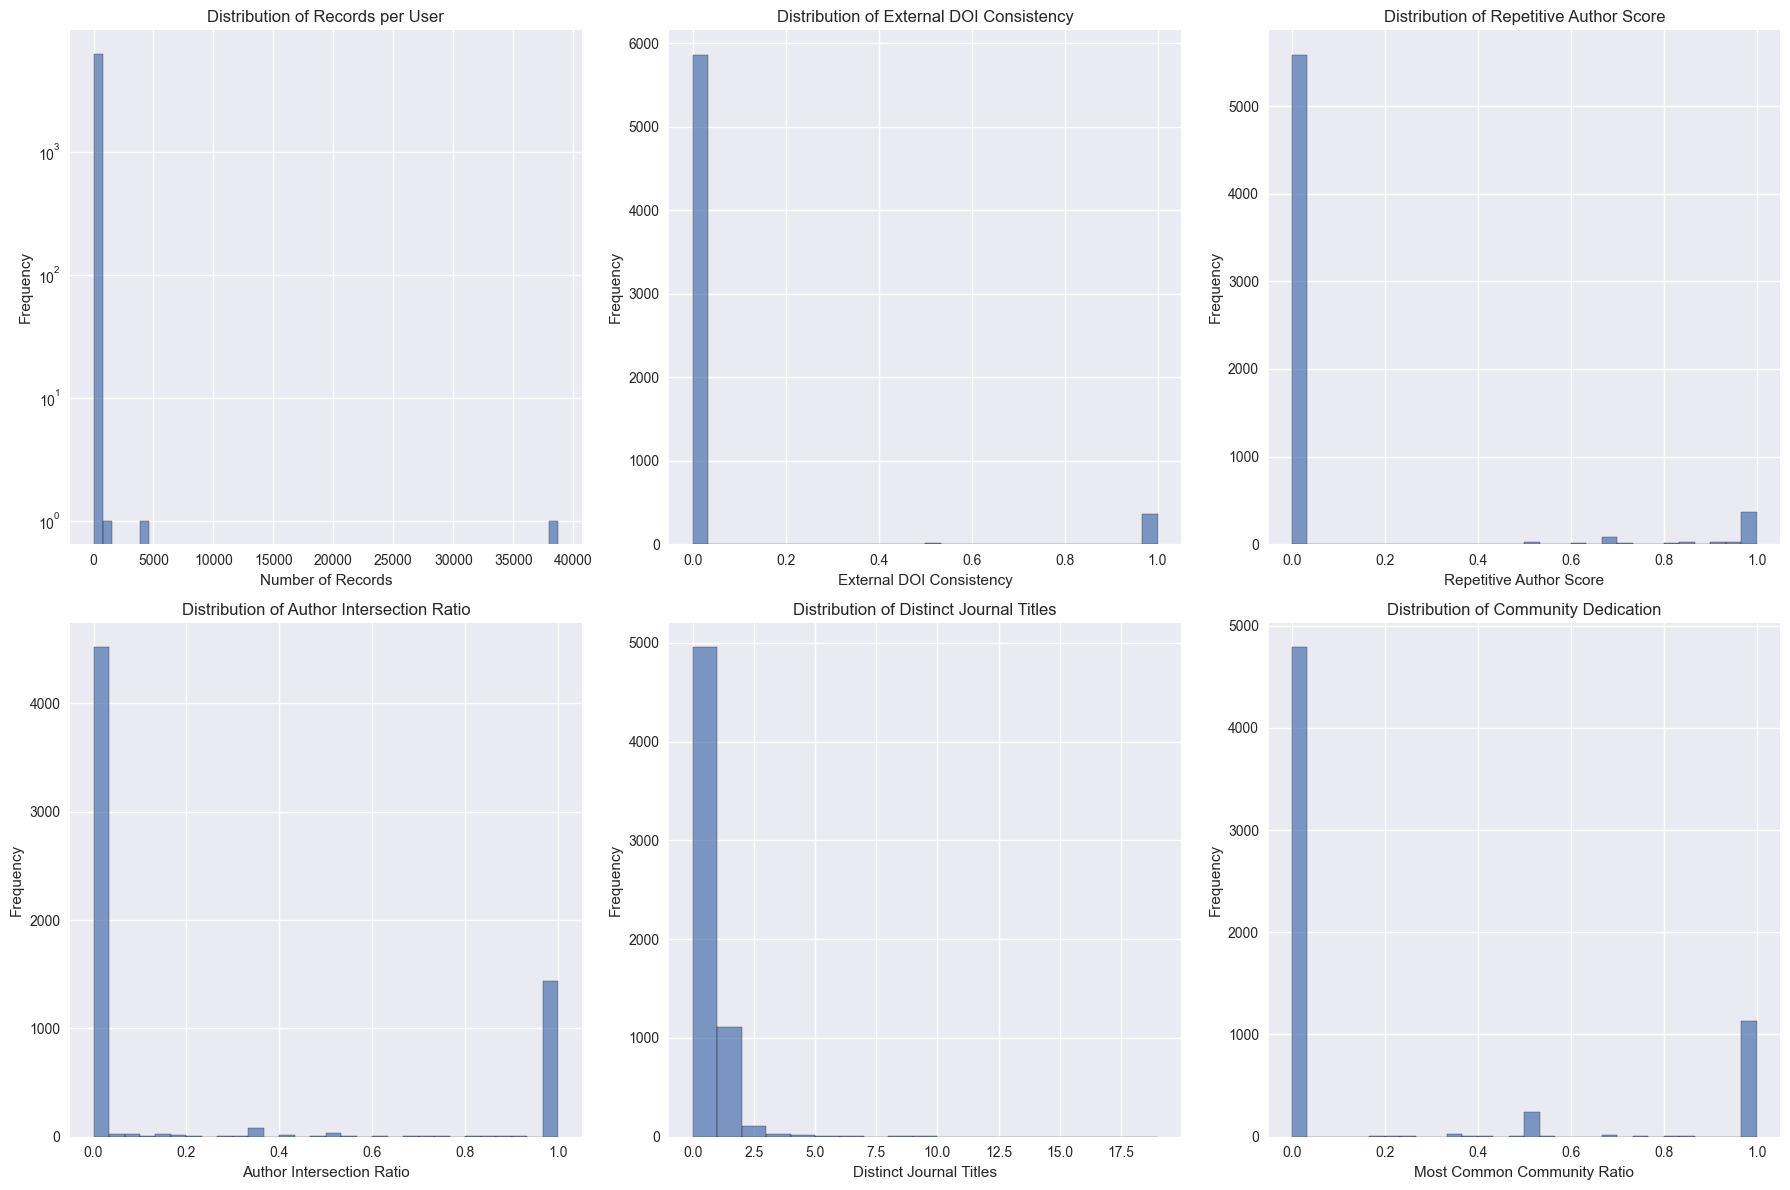

Feature distributions saved to figures/feature_distributions.png


In [96]:
# Set up plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# 1. Number of records distribution
axes[0].hist(users_df['n_records'], bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Number of Records')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Records per User')
axes[0].set_yscale('log')

# 2. External DOI consistency
axes[1].hist(users_df['external_doi_consistency'], bins=30, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('External DOI Consistency')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of External DOI Consistency')

# 3. Author analysis - repetitive author score
axes[2].hist(users_df['no_repetitive_author_score'], bins=30, alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Repetitive Author Score')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution of Repetitive Author Score')

# 4. Author intersection ratio
axes[3].hist(users_df['author_intersection_ratio'], bins=30, alpha=0.7, edgecolor='black')
axes[3].set_xlabel('Author Intersection Ratio')
axes[3].set_ylabel('Frequency')
axes[3].set_title('Distribution of Author Intersection Ratio')

# 5. Journal title count
axes[4].hist(users_df['distinct_journal_title_cnt'], bins=range(0, 20), alpha=0.7, edgecolor='black')
axes[4].set_xlabel('Distinct Journal Titles')
axes[4].set_ylabel('Frequency')
axes[4].set_title('Distribution of Distinct Journal Titles')

# 6. Community ratio
axes[5].hist(users_df['same_comm_ratio'], bins=30, alpha=0.7, edgecolor='black')
axes[5].set_xlabel('Most Common Community Ratio')
axes[5].set_ylabel('Frequency')
axes[5].set_title('Distribution of Community Dedication')

plt.tight_layout()
plt.savefig('figures/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Feature distributions saved to figures/feature_distributions.png")

## 7. Correlation Analysis

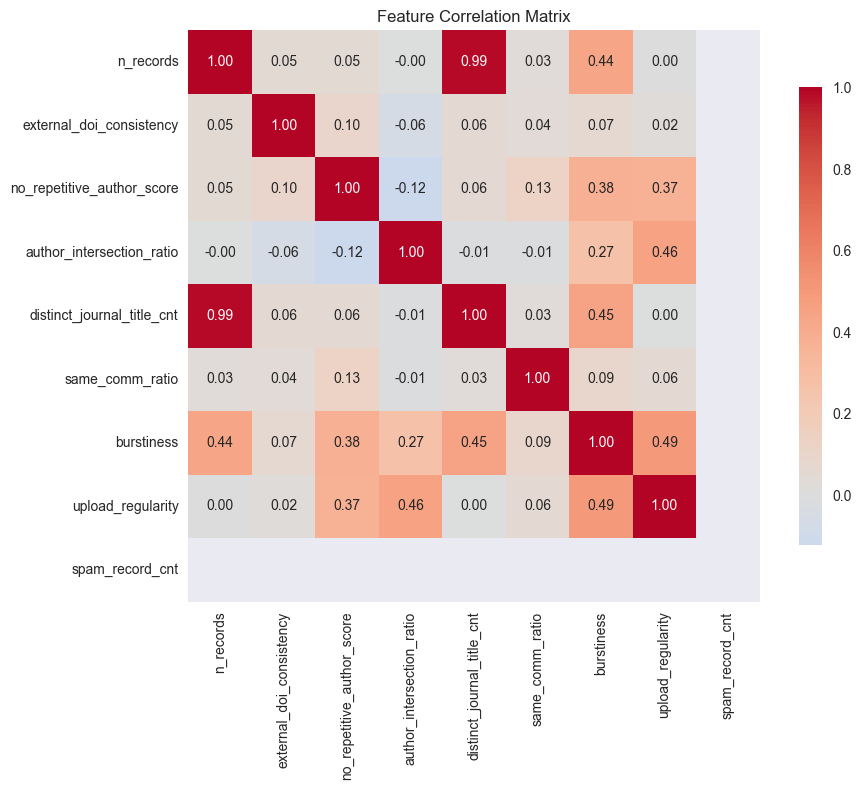

Correlation heatmap saved to figures/correlation_heatmap.png

Top feature correlations:
n_records vs distinct_journal_title_cnt: 0.990
n_records vs burstiness: 0.442
n_records vs spam_record_cnt: nan
external_doi_consistency vs spam_record_cnt: nan
no_repetitive_author_score vs spam_record_cnt: nan
author_intersection_ratio vs upload_regularity: 0.459
author_intersection_ratio vs spam_record_cnt: nan
distinct_journal_title_cnt vs burstiness: 0.451
no_repetitive_author_score vs burstiness: 0.377
no_repetitive_author_score vs upload_regularity: 0.369


In [97]:
# Select numeric features for correlation
numeric_features = ['n_records', 'external_doi_consistency', 'no_repetitive_author_score', 
                   'author_intersection_ratio', 'distinct_journal_title_cnt', 
                   'same_comm_ratio', 'burstiness', 'upload_regularity', 'spam_record_cnt']

# Create correlation matrix
correlation_matrix = users_df[numeric_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('figures/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Correlation heatmap saved to figures/correlation_heatmap.png")

# Show top correlations
print("\nTop feature correlations:")
correlations = []
for i in range(len(numeric_features)):
    for j in range(i+1, len(numeric_features)):
        feat1, feat2 = numeric_features[i], numeric_features[j]
        corr = correlation_matrix.loc[feat1, feat2]
        correlations.append((feat1, feat2, corr))

correlations.sort(key=lambda x: abs(x[2]), reverse=True)
for feat1, feat2, corr in correlations[:10]:
    print(f"{feat1} vs {feat2}: {corr:.3f}")

## 8. Scatter Plot Analysis

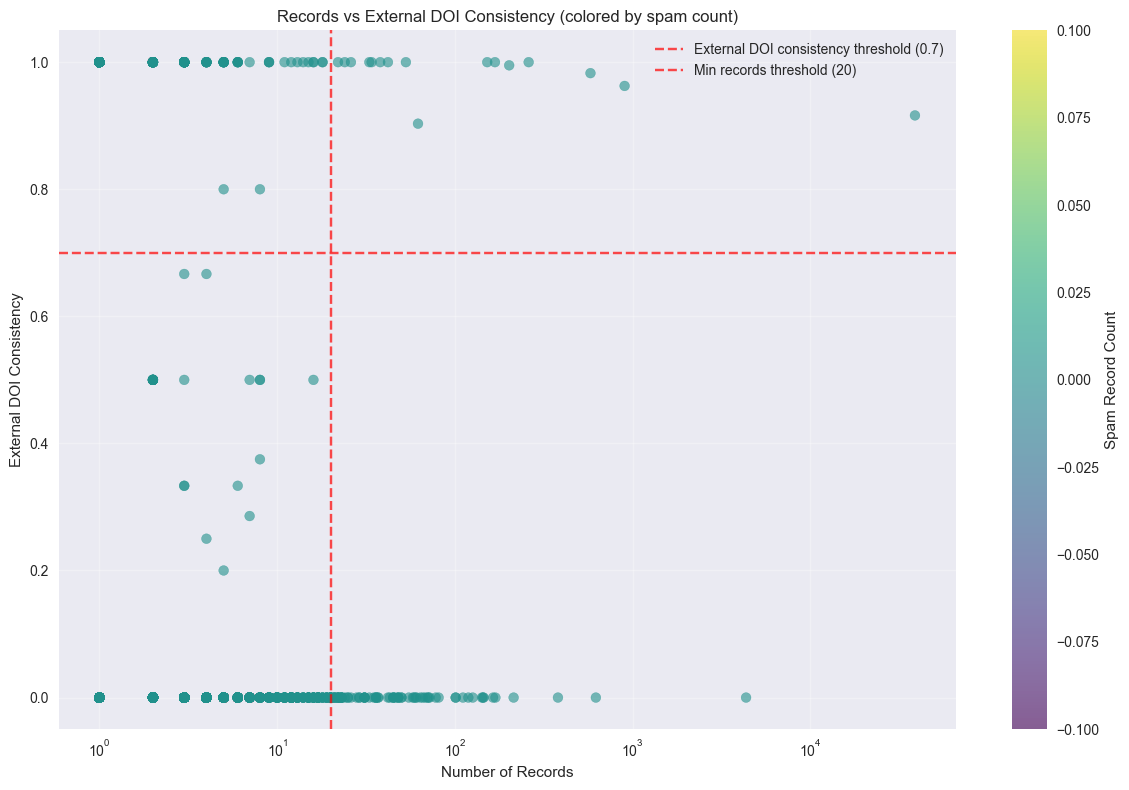

Scatter plot saved to figures/records_vs_external_doi_consistency.png


In [98]:
# Create scatter plot: n_records vs external_doi_consistency
plt.figure(figsize=(12, 8))

# Color by spam record count
scatter = plt.scatter(users_df['n_records'], users_df['external_doi_consistency'], 
                     c=users_df['spam_record_cnt'], cmap='viridis', 
                     alpha=0.6, s=50)

plt.xlabel('Number of Records')
plt.ylabel('External DOI Consistency')
plt.title('Records vs External DOI Consistency (colored by spam count)')
plt.xscale('log')
plt.colorbar(scatter, label='Spam Record Count')

# Add threshold lines
plt.axhline(y=CONFIG['external_doi_consistency_threshold'], color='red', linestyle='--', 
           alpha=0.7, label=f'External DOI consistency threshold ({CONFIG["external_doi_consistency_threshold"]})')
plt.axvline(x=CONFIG['min_records_threshold'], color='red', linestyle='--', 
           alpha=0.7, label=f'Min records threshold ({CONFIG["min_records_threshold"]})')

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/records_vs_external_doi_consistency.png', dpi=300, bbox_inches='tight')
plt.show()

print("Scatter plot saved to figures/records_vs_external_doi_consistency.png")

## 9. Pair Plot for Key Features

Creating pair plot with 1000 sampled users...


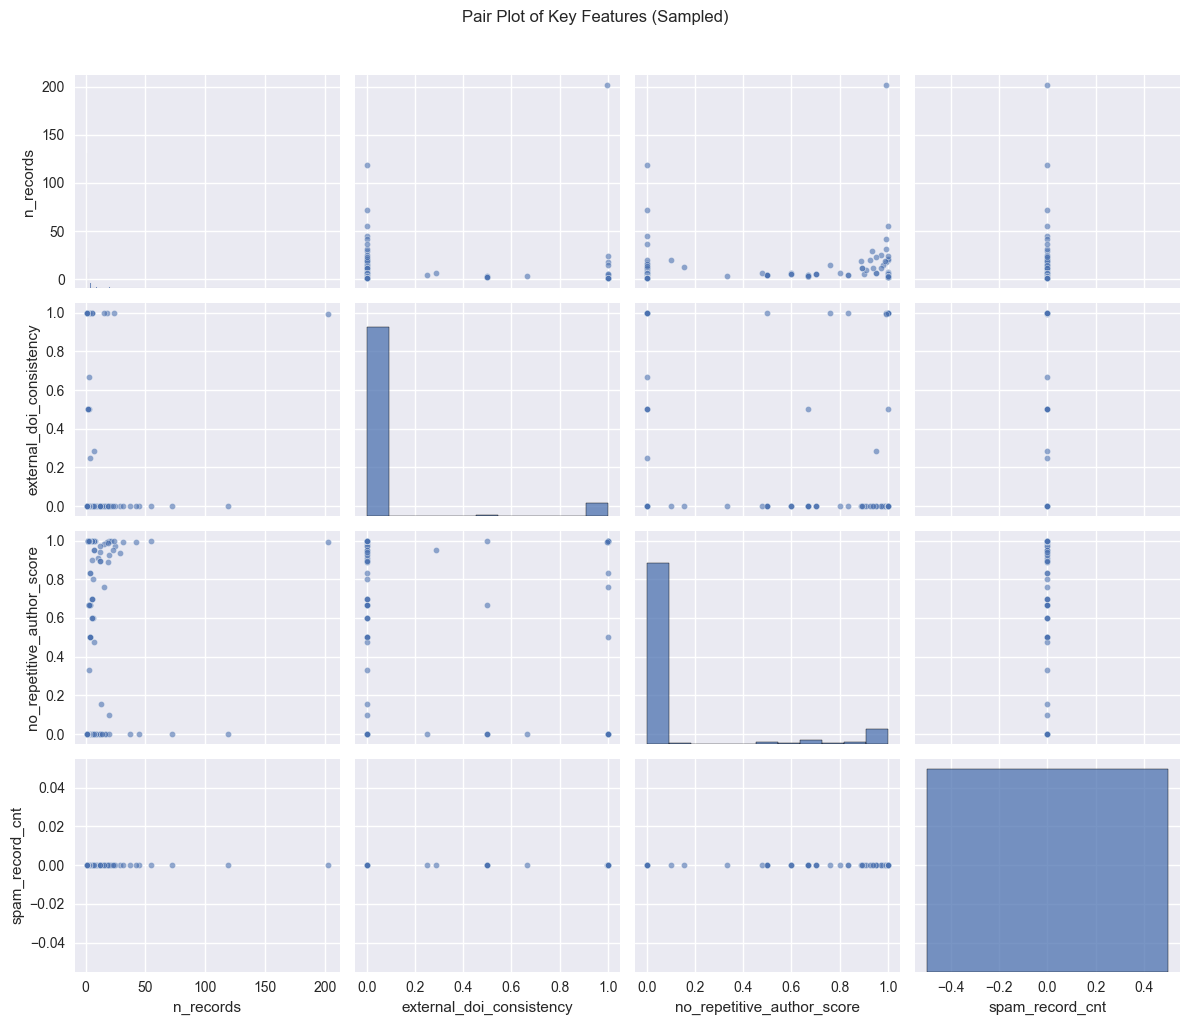

Pair plot saved to figures/pair_plot.png


In [99]:
# Create pair plot for key features (sample for performance)
key_features = ['n_records', 'external_doi_consistency', 'no_repetitive_author_score', 'spam_record_cnt']
sample_size = min(1000, len(users_df))
sample_df = users_df.sample(n=sample_size, random_state=42)

print(f"Creating pair plot with {sample_size} sampled users...")

pair_plot = sns.pairplot(sample_df[key_features], diag_kind='hist', 
                        plot_kws={'alpha': 0.6, 's': 20})
pair_plot.fig.suptitle('Pair Plot of Key Features (Sampled)', y=1.02)
pair_plot.fig.set_size_inches(12, 10)
plt.tight_layout()
plt.savefig('figures/pair_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Pair plot saved to figures/pair_plot.png")

## 10. Timeline Analysis for Top Candidates

Creating timeline plots for top 5 users by record count...


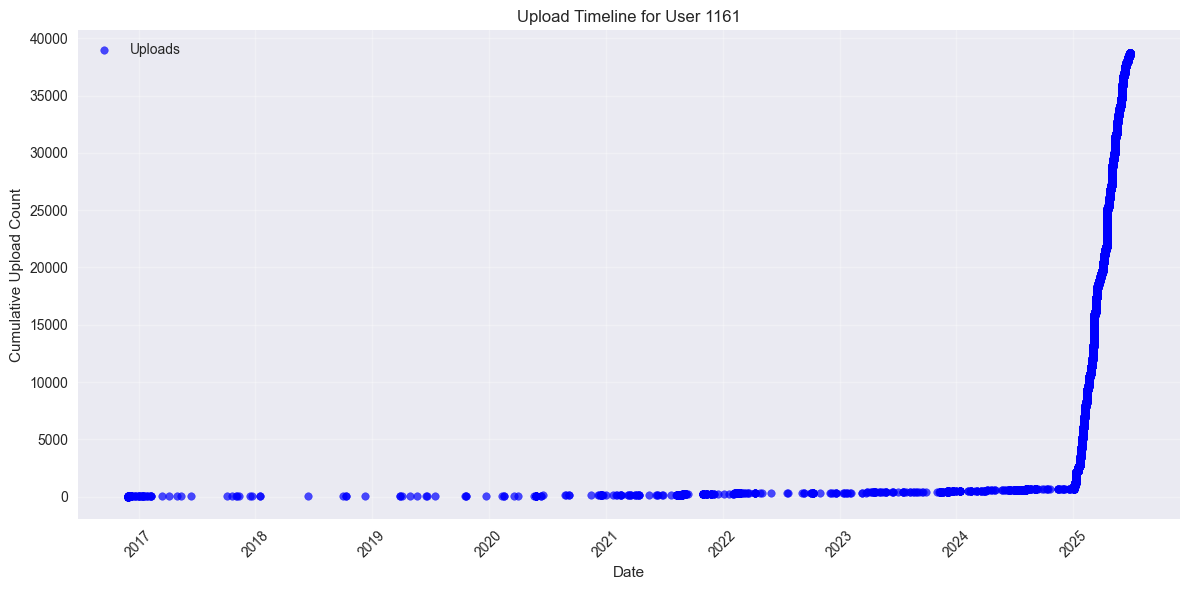

Timeline for user 1161 saved to figures/timeline_user_1161.png
  Records: 38758, External DOI consistency: 0.92, Spam records: 0


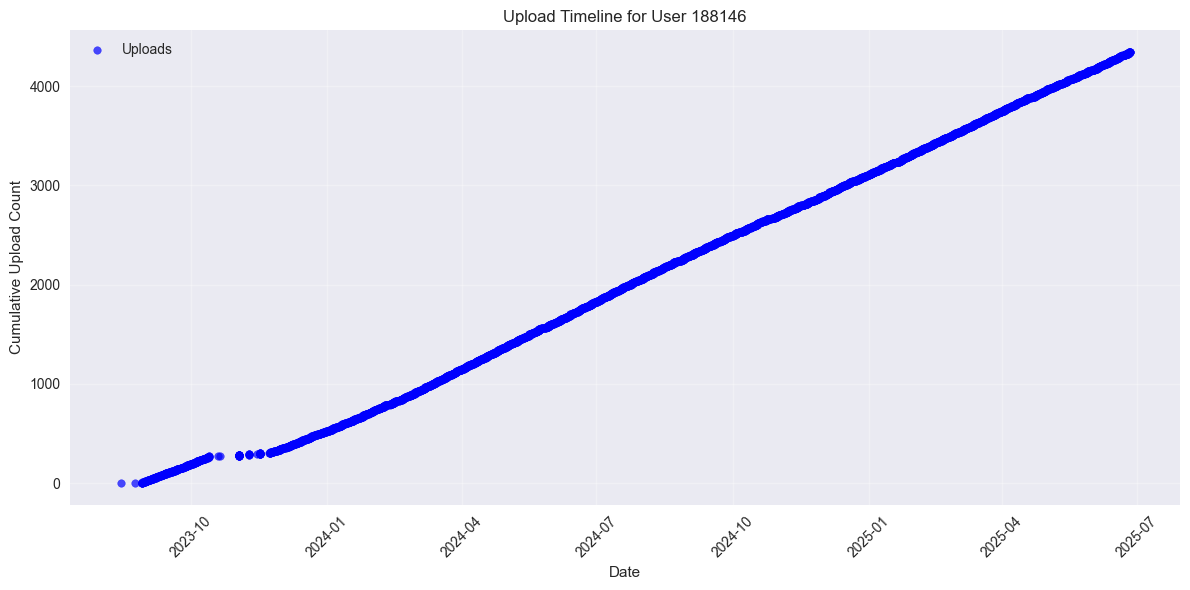

Timeline for user 188146 saved to figures/timeline_user_188146.png
  Records: 4347, External DOI consistency: 0.00, Spam records: 0


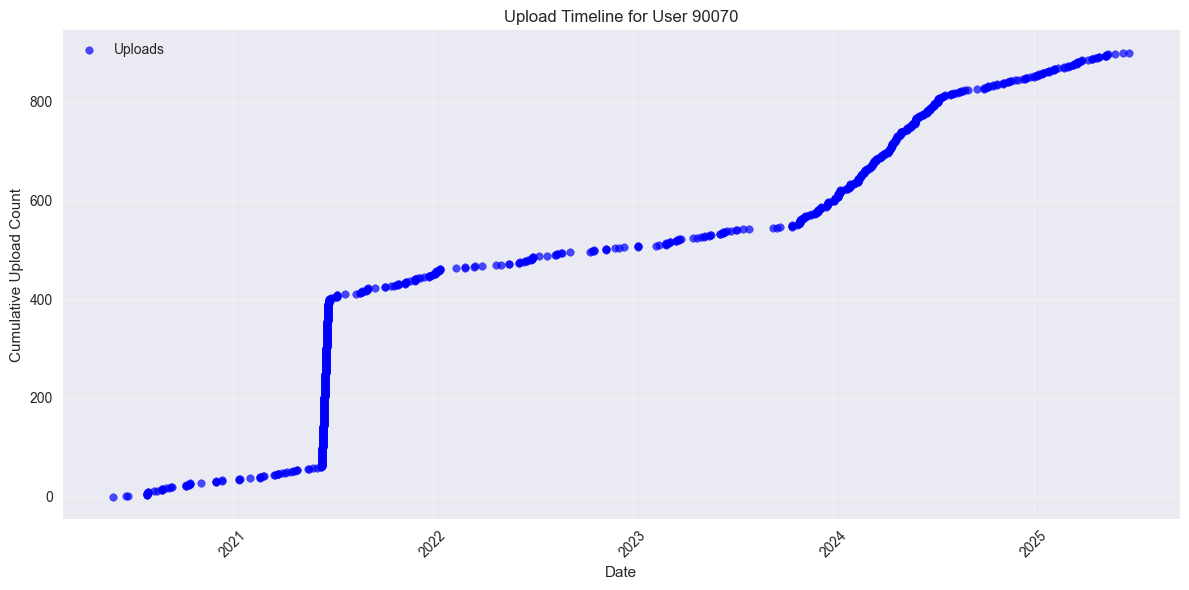

Timeline for user 90070 saved to figures/timeline_user_90070.png
  Records: 901, External DOI consistency: 0.96, Spam records: 0


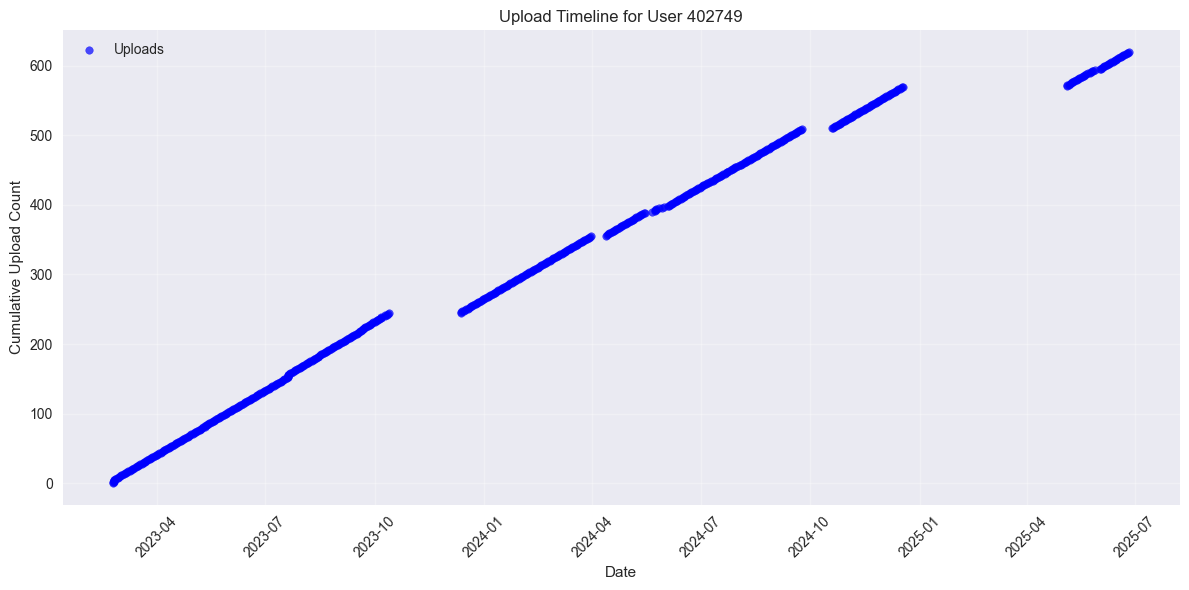

Timeline for user 402749 saved to figures/timeline_user_402749.png
  Records: 621, External DOI consistency: 0.00, Spam records: 0


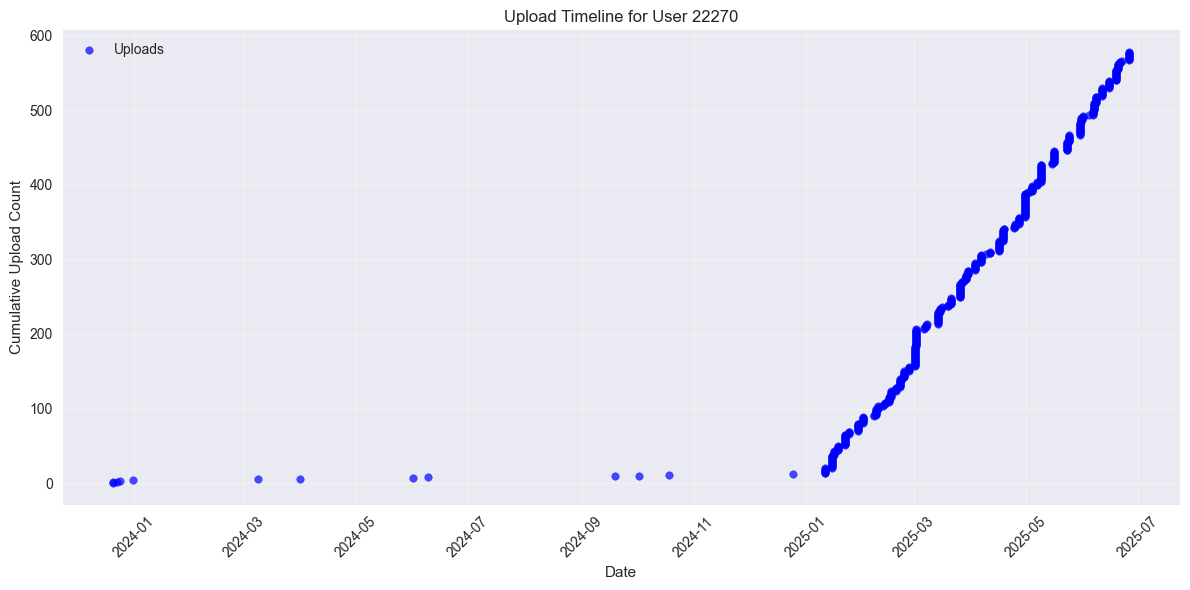

Timeline for user 22270 saved to figures/timeline_user_22270.png
  Records: 579, External DOI consistency: 0.98, Spam records: 0


In [100]:
def plot_user_timeline(user_id, records_df):
    """Plot upload timeline for a specific user."""
    user_records = records_df[records_df['user_id'] == user_id].copy()
    user_records = user_records.sort_values('created')
    
    plt.figure(figsize=(12, 6))
    
    # Plot uploads over time
    plt.scatter(user_records['created'], range(len(user_records)), 
               alpha=0.7, s=30, c='blue', label='Uploads')
    
    # Highlight spam records
    spam_records = user_records[user_records['is_spam_record']]
    if len(spam_records) > 0:
        plt.scatter(spam_records['created'], 
                   [list(user_records['created']).index(t) for t in spam_records['created']], 
                   alpha=0.8, s=50, c='red', label='Spam Records', marker='x')
    
    plt.xlabel('Date')
    plt.ylabel('Cumulative Upload Count')
    plt.title(f'Upload Timeline for User {user_id}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return plt.gcf()

# Get top 5 users by record count
top_users = users_df.nlargest(5, 'n_records')['user_id'].tolist()

print("Creating timeline plots for top 5 users by record count...")

for i, user_id in enumerate(top_users):
    fig = plot_user_timeline(user_id, records_df)
    plt.savefig(f'figures/timeline_user_{user_id}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Timeline for user {user_id} saved to figures/timeline_user_{user_id}.png")
    
    # Show user stats
    user_stats = users_df[users_df['user_id'] == user_id].iloc[0]
    print(f"  Records: {user_stats['n_records']}, External DOI consistency: {user_stats['external_doi_consistency']:.2f}, "
          f"Spam records: {user_stats['spam_record_cnt']}")

## 11. Journal Runner Candidate Detection

In [101]:
# Apply heuristic filter for journal runner candidates
print("Applying journal runner detection heuristics...")

candidates = users_df[
    (users_df['n_records'] >= CONFIG['min_records_threshold']) &
    (users_df['external_doi_consistency'] >= CONFIG['external_doi_consistency_threshold']) &
    (users_df['upload_regularity'] >= CONFIG['min_upload_regularity']) &
    (users_df['spam_record_ratio'] <= CONFIG['max_spam_ratio']) &
    (~users_df['has_safe_community']) &  # Exclude users with safe communities
    (users_df['no_repetitive_author_score'] >= CONFIG['repetitive_author_threshold'])  # High repetitive author score
].sort_values('external_doi_consistency', ascending=False)

print(f"\nFound {len(candidates)} users meeting journal runner criteria")
print(f"Out of {len(users_df)} total users with >= {CONFIG['min_records_threshold']} records")

# Display top candidates
print("\nTop 20 Journal Runner Candidates:")
display_columns = ['user_id', 'n_records', 'external_doi_consistency', 'no_repetitive_author_score', 
                  'author_intersection_ratio', 'upload_regularity', 'spam_record_ratio', 'burstiness']

# Print candidates table instead of using display
print(candidates[display_columns].head(20).to_string(index=False))

# Save candidates to CSV
candidates.to_csv('data/journal_runner_candidates.csv', index=False)
print("\nCandidates saved to data/journal_runner_candidates.csv")

Applying journal runner detection heuristics...

Found 11 users meeting journal runner criteria
Out of 6254 total users with >= 20 records

Top 20 Journal Runner Candidates:
user_id  n_records  external_doi_consistency  no_repetitive_author_score  author_intersection_ratio  upload_regularity  spam_record_ratio  burstiness
1032827         33                  1.000000                    0.967803                   0.032197           0.292393                0.0    2.420055
1091877         34                  1.000000                    0.989305                   0.010695           0.287815                0.0    2.474448
 131527         22                  1.000000                    0.956710                   0.043290           0.317696                0.0    2.147667
 203484         42                  1.000000                    0.977933                   0.022067           0.282152                0.0    2.544193
 250449        152                  1.000000                    0.996689    

## 12. Summary Statistics and Insights

In [102]:
# Generate summary statistics
print("=" * 60)
print("ZENODO JOURNAL RUNNER DETECTION - SUMMARY REPORT")
print("=" * 60)

total_users = len(users_df)
users_with_50_plus = len(users_df[users_df['n_records'] >= 50])
candidate_count = len(candidates)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   • Total users analyzed: {total_users:,}")
print(f"   • Users with ≥50 records: {users_with_50_plus:,} ({users_with_50_plus/total_users*100:.1f}%)")
print(f"   • Journal runner candidates: {candidate_count:,} ({candidate_count/users_with_50_plus*100:.1f}% of high-volume users)")

print(f"\n🎯 DETECTION CRITERIA APPLIED:")
print(f"   • Minimum records: {CONFIG['min_records_threshold']}")
print(f"   • External DOI consistency threshold: {CONFIG['external_doi_consistency_threshold']}")
print(f"   • Max external prefixes: {CONFIG['max_external_prefixes']}")
print(f"   • Min upload regularity: {CONFIG['min_upload_regularity']}")
print(f"   • Max spam ratio: {CONFIG['max_spam_ratio']}")
print(f"   • Min repetitive author score: {CONFIG['repetitive_author_threshold']}")
print(f"   • Exclude safe communities: {CONFIG['safe_communities']}")

print(f"\n📈 CANDIDATE CHARACTERISTICS:")
if len(candidates) > 0:
    print(f"   • Average records per candidate: {candidates['n_records'].mean():.1f}")
    print(f"   • Average External DOI consistency: {candidates['external_doi_consistency'].mean():.3f}")
    print(f"   • Average repetitive author score: {candidates['no_repetitive_author_score'].mean():.3f}")
    print(f"   • Average community dedication: {candidates['same_comm_ratio'].mean():.3f}")
    print(f"   • Users with spam records: {len(candidates[candidates['spam_record_cnt'] > 0])} "
          f"({len(candidates[candidates['spam_record_cnt'] > 0])/len(candidates)*100:.1f}%)")

print(f"\n🔍 KEY INSIGHTS:")
print(f"   • {len(users_df[users_df['external_doi_consistency'] == 1.0]):,} users use exclusively external DOIs")
print(f"   • {len(users_df[users_df['same_comm_ratio'] == 1.0]):,} users are dedicated to a single community")
print(f"   • {len(users_df[users_df['spam_record_cnt'] > 0]):,} users have spam records associated")
print(f"   • {len(users_df[users_df['has_safe_community']]):,} users have safe communities (independent users)")
print(f"   • {len(users_df[users_df['no_repetitive_author_score'] >= 0.5]):,} users have high repetitive author scores (≥0.5)")

print(f"\n💾 OUTPUT FILES GENERATED:")
print(f"   • data/records.parquet - Processed record data")
print(f"   • data/users.parquet - User-level features")
print(f"   • data/journal_runner_candidates.csv - Candidate list")
print(f"   • figures/ - Visualization plots")

print(f"\n" + "=" * 60)
print(f"ANALYSIS COMPLETE: Found {candidate_count} potential journal runners")
print("=" * 60)

ZENODO JOURNAL RUNNER DETECTION - SUMMARY REPORT

📊 DATASET OVERVIEW:
   • Total users analyzed: 6,254
   • Users with ≥50 records: 38 (0.6%)
   • Journal runner candidates: 11 (28.9% of high-volume users)

🎯 DETECTION CRITERIA APPLIED:
   • Minimum records: 20
   • External DOI consistency threshold: 0.7
   • Max external prefixes: 3
   • Min upload regularity: 0.1
   • Max spam ratio: 0.1
   • Min repetitive author score: 0.3
   • Exclude safe communities: ['eu', 'biosyslit']

📈 CANDIDATE CHARACTERISTICS:
   • Average records per candidate: 141.0
   • Average External DOI consistency: 0.987
   • Average repetitive author score: 0.986
   • Average community dedication: 0.257
   • Users with spam records: 0 (0.0%)

🔍 KEY INSIGHTS:
   • 364 users use exclusively external DOIs
   • 1,127 users are dedicated to a single community
   • 0 users have spam records associated
   • 238 users have safe communities (independent users)
   • 619 users have high repetitive author scores (≥0.5)

💾 OU

## 13. Additional Analysis: Feature Importance

posx and posy should be finite values
posx and posy should be finite values


Analyzing feature importance for journal runner detection...


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


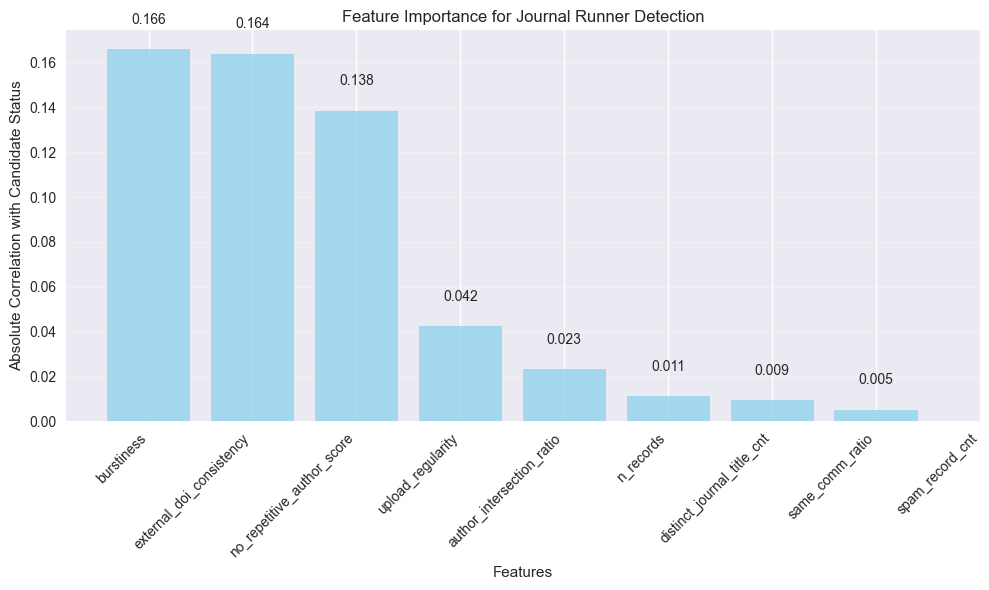

Feature importance plot saved to figures/feature_importance.png

Feature importance ranking:
  burstiness: 0.166
  external_doi_consistency: 0.164
  no_repetitive_author_score: 0.138
  upload_regularity: 0.042
  author_intersection_ratio: 0.023
  n_records: 0.011
  distinct_journal_title_cnt: 0.009
  same_comm_ratio: 0.005
  spam_record_cnt: nan


In [103]:
# Analyze feature importance for candidate detection
print("Analyzing feature importance for journal runner detection...")

# Create binary target: is candidate or not
users_df['is_candidate'] = users_df['user_id'].isin(candidates['user_id'])

# Calculate feature importance using correlation with target
feature_importance = {}
for feature in numeric_features:
    correlation = users_df[feature].corr(users_df['is_candidate'])
    feature_importance[feature] = abs(correlation)

# Sort by importance
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Plot feature importance
plt.figure(figsize=(10, 6))
features, importance = zip(*sorted_importance)
bars = plt.bar(range(len(features)), importance, color='skyblue', alpha=0.7)
plt.xlabel('Features')
plt.ylabel('Absolute Correlation with Candidate Status')
plt.title('Feature Importance for Journal Runner Detection')
plt.xticks(range(len(features)), features, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, imp in zip(bars, importance):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{imp:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Feature importance plot saved to figures/feature_importance.png")
print("\nFeature importance ranking:")
for feature, imp in sorted_importance:
    print(f"  {feature}: {imp:.3f}") 